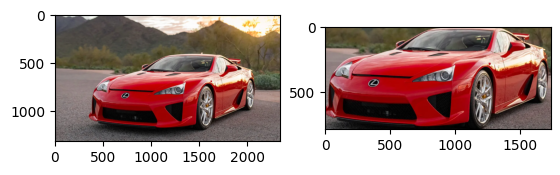

In [23]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
model = YOLO("yolov8n.pt")
result = model('lfa.jpg')[0]
x1, y1, x2, y2 = result.boxes[0].xyxy[0].tolist()
img = Image.open('lfa.jpg')
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(np.array(img)[int(y1):int(y2),int(x1):int(x2)])


In [30]:
%%writefile main.py
##YOLO + MotionDetector
import cv2 as cv
import numpy as np
import yaml
import utils
from human_alert import Alert
from classifier import ObjectClassifier
import time

# Config
CONFIG_PATH = "../config/config.yaml"
with open(CONFIG_PATH, "r" , encoding="utf-8") as f:
    cfg = yaml.safe_load(f)
    
#Video 
video = cv.VideoCapture(cfg["video"]["source"])

#Alert System 
alert = Alert(5)

#Classifier
if cfg['detector']['enabled']:
    classifier = ObjectClassifier(weights_path=cfg['detector']['weights_path'],
                                  conf_threshold=cfg['detector']['conf_threshold'],
                                  allowed_classes=cfg['detector']['allowed_classes'])
else:
    classifier = None
    
frame_idx = 0
DETECT_EVERY = 3 # skip frame for optimization

last_detection = None
stale_frames = 0
STALE_LIMIT = 5 

prev_time = time.time()
fps = 0
#Base Loop
while True:
    _,frame = video.read()
    if frame is None :
        break
    frame_idx += 1  
    run_detection = (frame_idx % DETECT_EVERY == 0)
    
    resized_frame = utils.rescaleFrame(frame,1)
        
    if classifier is not None and run_detection:
        chosen_detection = classifier.detect(resized_frame)
        if chosen_detection is not None:
            last_detection = chosen_detection
            stale_frames = 0   
        else:
            stale_frames += 1
             
        if last_detection is not None and stale_frames < STALE_LIMIT:
            x1,y1,x2,y2 = last_detection['bbox']
            if cfg['debug']['show_contours']:

                cv.rectangle(resized_frame,(x1,y1),(x2,y2),(0,0,255),thickness=2)
                label_text = last_detection["label"]
                cv.putText(resized_frame, label_text, (x1, y1-10),cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    #Show FPS
    current_time = time.time()
    delta = current_time - prev_time
    if delta > 0:
        fps = 1 / delta
    prev_time = current_time
    cv.putText(resized_frame,f"FPS: {fps:.1f}",(10, 30),cv.FONT_HERSHEY_SIMPLEX,0.7,(0, 255, 0),2)

    cv.imshow("Display",resized_frame)
    
    if cfg['alert']['enabled']:
        alert.printAlert(last_detection)
        
    if cv.waitKey(20) & 0xFF==ord('0'):
            break

video.release()
cv.destroyAllWindows()    

Overwriting main.py


In [25]:
%%writefile utils.py
import cv2 as cv
def rescaleFrame(frame,scale=0.5):
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)
    dimentions = (width,height)
    return cv.resize(frame,dimentions,interpolation = cv.INTER_AREA)

Overwriting utils.py


In [26]:
%%writefile classifier.py
from ultralytics import YOLO
from ultralytics.utils import LOGGER
import torch

LOGGER.setLevel(50)

class ObjectClassifier:
    def __init__(self, weights_path="yolov8n.pt", conf_threshold=0.5 , allowed_classes={"person", "cat"}):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        self.model = YOLO(weights_path)
        self.model.to(self.device)         

        self.conf_threshold = conf_threshold
        self.allowed_classes = set(allowed_classes) if allowed_classes else None

    def detect(self, frame):
        results = self.model(frame, device=self.device)[0]
        chosen_detection = None
        for box in results.boxes:
            cls_id = int(box.cls[0])
            score = float(box.conf[0])
            label = self.model.names[cls_id]

            if score >= self.conf_threshold and label in self.allowed_classes:
                x1, y1, x2, y2 = box.xyxy[0].tolist()
                chosen_detection = {
                    "label": label,
                    "score": score,
                    "bbox": (int(x1), int(y1), int(x2), int(y2))
                }
                break
        return chosen_detection


Overwriting classifier.py


In [31]:
%%writefile human_alert.py
import time
class Alert:
    def __init__(self,alert_interval):
        self.ALERT_INTERVAL = alert_interval


    def printAlert(self,detected_object):
        last_alert_time = 0
        if detected_object is not None:
            now = time.time()
            if now - last_alert_time > self.ALERT_INTERVAL:
                print(f"[ALERT] {detected_object['label']} detected at {time.ctime(now)}")
                last_alert_time = now


Overwriting human_alert.py


In [28]:
%%writefile motion_detector.py
import cv2 as cv
from background_subtractor import BackgroundSubtractor
import yaml

CONFIG_PATH = "../config/config.yaml"
with open(CONFIG_PATH, "r" , encoding="utf-8") as f:
    cfg = yaml.safe_load(f)
    
class MotionDetector:
    
    def __init__(self):
        self.fgbg = BackgroundSubtractor(method=cfg['background']['method'])
        self.clean = None
        self.fg_mask = None
        self.contours = []
        
        
        
    def update(self,frame,min_area:int=300,learningRate:float=.01):
        fg_mask = self.fgbg.apply(frame,learningRate)
        self.fg_mask = fg_mask
        
        blur = cv.GaussianBlur(fg_mask,(cfg['preprocess']['blur_kernel'],cfg['preprocess']['blur_kernel']),0)
    
        _, thresh = cv.threshold( blur, cfg['preprocess']['threshold'], 255, cv.THRESH_BINARY) 
    
        kernel = cv.getStructuringElement(cv.MORPH_RECT, (cfg['preprocess']['morph_kernel'], cfg['preprocess']['morph_kernel']))
    
        clean = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=cfg['preprocess']['morph_iterations'])
    
        clean = cv.dilate(clean, kernel, iterations=cfg['preprocess']['dilate_iterations'])
        self.clean = clean
        
        contours, _ = cv.findContours(clean, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        self.contours = contours
        
        motions = []
        for cnt in self.contours:
            area = cv.contourArea(cnt)
            if area < min_area:
                continue
            x, y, w, h = cv.boundingRect(cnt)
            motions.append((x, y, w, h))
        return motions   

        
    def show(self):
        cv.imshow("Clean",self.clean)
        cv.imshow("FG_Mask",self.fg_mask)

Overwriting motion_detector.py


In [29]:
%%writefile background_subtractor.py
import cv2 as cv
import yaml

CONFIG_PATH = "../config/config.yaml"
with open(CONFIG_PATH, "r" , encoding="utf-8") as f:
    cfg = yaml.safe_load(f)
    
class BackgroundSubtractor:
    def __init__(self, method="mog2"):
        if method == "mog2":
            self.model = cv.createBackgroundSubtractorMOG2(history=cfg['background']['history'],
                                                           varThreshold=cfg['background']['var_threshold'],
                                                           detectShadows=cfg['background']['detect_shadows'])
        elif method == "knn":
            self.model = cv.createBackgroundSubtractorKNN(detectShadows=cfg['background']['detect_shadows'])
        else:
            raise ValueError("Unknown method")

    def apply(self, frame,lr=0.01):
        fg_mask = self.model.apply(frame,lr)
        return fg_mask

Overwriting background_subtractor.py
